In [18]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, get_scorer_names
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/merge_all/merge_all.csv", index_col=0)
# df.info()

In [3]:
# 인덱스를 datetime으로 변경
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")
# df.index
# df.info()

In [4]:
# rolling 메소드를 이용한 이동평균 만들기
mov_list = [7,28]
for mov in mov_list :
    globals()["df_mov_avr"+str(mov)] = df["평균"].rolling(mov, min_periods=1).mean()

In [5]:
df_yester = df["평균"].shift(1)      # 전날 가격을 추출
df_yester[0] = (6040+5160)/2        # 1999년 12월 31일 배추 평균값
# df_yester

In [6]:
df = pd.concat([df, df_yester ,df_mov_avr7, df_mov_avr28],axis=1)
# df

In [7]:
df.columns = ["자동차용 경유 가격 (원)", "전월비(%)", "평균 가격(원)", "거래량 (kg)", "전일 평균가격" ,"이동 평균가격_7일","이동 평균가격_28일"]
# df.info()

In [8]:
feature = df[["자동차용 경유 가격 (원)", "전월비(%)", "거래량 (kg)", "전일 평균가격" ,"이동 평균가격_7일","이동 평균가격_28일"]]
target = df["평균 가격(원)"]

In [9]:
std = StandardScaler()
std.fit(feature)
feature_std = std.transform(feature)

In [10]:
# feature_std

In [11]:
std2 = StandardScaler()
std2.fit(target.values.reshape(-1,1))
target_std = std2.transform(target.values.reshape(-1,1))
# target_std.shape

In [36]:
# 가격을 제외한 독립 변수 선택
feature_execpt_price = df[["자동차용 경유 가격 (원)", "전월비(%)", "거래량 (kg)"]]

In [37]:
std_except_price = StandardScaler()
std_except_price.fit(feature_execpt_price)
feature_std_except_price = std_except_price.transform(feature_execpt_price)

In [39]:
# 전날 가격 포함 독립변수
feature_yes_price = df[["자동차용 경유 가격 (원)", "전월비(%)", "거래량 (kg)", "전일 평균가격"]]

std_yes_price = StandardScaler()
std_yes_price.fit(feature_yes_price)
feature_std_yes_price = std_yes_price.transform(feature_yes_price)

## LSTM

In [24]:
# 딥러닝용 tensor로 변환
X_train, X_test = feature_std[:6696].reshape(-1,3,1.), feature_std[6696:].reshape(-1,3,1)
y_train, y_test = target_std[:6696], target_std[6696:]

In [25]:
model = Sequential()
model.add(LSTM(units=3, input_shape=(X_train.shape[1],1), activation="tanh", ))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer = "adam", metrics=["mse"])

In [26]:
model.fit(X_train, y_train ,epochs=300, verbose=2)

Epoch 1/300
210/210 - 4s - loss: 0.6320 - mse: 0.6320 - 4s/epoch - 19ms/step
Epoch 2/300
210/210 - 1s - loss: 0.5932 - mse: 0.5932 - 533ms/epoch - 3ms/step
Epoch 3/300
210/210 - 1s - loss: 0.5767 - mse: 0.5767 - 541ms/epoch - 3ms/step
Epoch 4/300
210/210 - 1s - loss: 0.5688 - mse: 0.5688 - 514ms/epoch - 2ms/step
Epoch 5/300
210/210 - 1s - loss: 0.5641 - mse: 0.5641 - 515ms/epoch - 2ms/step
Epoch 6/300
210/210 - 1s - loss: 0.5604 - mse: 0.5604 - 506ms/epoch - 2ms/step
Epoch 7/300
210/210 - 1s - loss: 0.5571 - mse: 0.5571 - 508ms/epoch - 2ms/step
Epoch 8/300
210/210 - 1s - loss: 0.5542 - mse: 0.5542 - 513ms/epoch - 2ms/step
Epoch 9/300
210/210 - 1s - loss: 0.5520 - mse: 0.5520 - 539ms/epoch - 3ms/step
Epoch 10/300
210/210 - 1s - loss: 0.5497 - mse: 0.5497 - 514ms/epoch - 2ms/step
Epoch 11/300
210/210 - 1s - loss: 0.5484 - mse: 0.5484 - 509ms/epoch - 2ms/step
Epoch 12/300
210/210 - 1s - loss: 0.5467 - mse: 0.5467 - 514ms/epoch - 2ms/step
Epoch 13/300
210/210 - 1s - loss: 0.5450 - mse: 0.5

In [27]:
model.evaluate(X_test, y_test)

53/53 [==============================] - 1s 2ms/step - loss: 2.0997 - mse: 2.0997


[2.099684238433838, 2.099684238433838]

In [28]:
y_pred = model.predict(X_test)
print("r2 score :", r2_score(y_test, y_pred))

r2 score : -0.20122443902116371


In [30]:
y_pred_in = std2.inverse_transform(y_pred)

In [ ]:
fig = plt.figure((15,9))
plt.plot(df)

## GridSearchCV

In [13]:
kfold = KFold(n_splits=10, shuffle=True, random_state=22)

iteration은 1 epoch를 시행할 때 필요한 미니배치 갯수를 의미합니다. 다른 말로는 1epoch을 마치는데 필요한 파라미터 업데이트 횟수

만약 10,000개의 데이터셋을 학습시킨다고 치자. (여기서 학습은 순방향 역방향 둘 다 포함)

메모리 한계 및 성능을 고려하여 나눠서 학습을 시킬 겁니다. 

이 때, 한 턴에 1,000개씩 10번 , 5턴을 학습시킨다고 하면, batch_size = 1,000 / iteration = 10 /epoch = 5입니다.

In [20]:
alpha = np.logspace(-4,2,7)   # lasso, ridge 해당
learning_rate = np.logspace(-4,2,7)   # adaboost, gradientboost 해당
eta = np.logspace(-4,2,7)   # xgboost 해당
max_iter = [1,3,5,10,20,50,100,150,200]   # lasso, ridge 해당
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']   # ridge 해당, 계산에 사용할 알고리즘
n_estimators = [1,3,5,10,15,20]   # randomforesteregressor(사용할 tree의 개수), gradientboost, adaboost, xgboost 해당
max_depth = [2,3,5,7,10,12]  # randomforesteregressor(tree의 깊이), gradientboost, xgboost 해당
criterion_rf = ["squared_error", "absolute_error", "friedman_mse", "poisson"]  # randomforesteregressor 해당
criterion_gb = ["squared_error", "friedman_mse"]  # gradientboost 해당
loss_ada = ["linear", "square", "exponential"]    # adaboost 해당
loss_gb = ["squared_error", "absolute_error", "huber", "quantile"]  # gradientboost 해당


In [28]:
model_lasso = ["Lasso"]
model_ridge = ["Ridge"]
model_rf = ["RandomForestRegressor"]
model_ada = ["AdaBoostRegressor"] 
model_grad = ["GradientBoostingRegressor"]
model_xgb = ["XGBRegressor"]

params_lasso = {"alpha" : alpha, 
                "max_iter" : max_iter}

params_ridge = {"alpha" : alpha, 
                "max_iter" : max_iter, 
                "solver" : solver}

params_rf = {"n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                "criterion" : criterion_rf}

params_ada = {"learning_rate" : learning_rate, 
                "n_estimators" : n_estimators, 
                "loss" : loss_ada
                }

params_grad = {"learning_rate" : learning_rate, 
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth,
                "criterion" : criterion_gb}

params_xgb = {"eta" : eta,
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                }

In [68]:
# lasso gridsearchcv
lasso = Lasso()
grid_lasso = GridSearchCV(estimator=lasso, param_grid=params_lasso, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_lasso.fit(feature_std, target_std)
print("Best Score :", grid_lasso.best_score_)
print("Best Parameters :", grid_lasso.best_params_)

Best Score : -0.009160113859789262
Best Parameters : {'alpha': 0.0001, 'max_iter': 200}


In [69]:
# ridge gridsearchcv
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge, param_grid=params_ridge, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_ridge.fit(feature_std, target_std)
print("Best Score :", grid_ridge.best_score_)
print("Best Parameters :", grid_ridge.best_params_)


Best Score : -0.009156406654891324
Best Parameters : {'alpha': 0.001, 'max_iter': 150, 'solver': 'sag'}


In [26]:
# RandomForestRegressor gridsearchcv
rf = RandomForestRegressor()
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_rf.fit(feature_std, target_std)
print("Best Score :", grid_rf.best_score_)
print("Best Parameters :", grid_rf.best_params_)

Best Score : -0.009954545782738902
Best Parameters : {'criterion': 'absolute_error', 'max_depth': 7, 'n_estimators': 20}


In [29]:
# adaboost gridsearchcv
ada = AdaBoostRegressor()
grid_ada = GridSearchCV(estimator=ada, param_grid=params_ada, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_ada.fit(feature_std, target_std)
print("Best Score :", grid_ada.best_score_)
print("Best Parameters :", grid_ada.best_params_)

Best Score : -0.01999911541714563
Best Parameters : {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 15}


In [30]:
# gradientboost gridsearchcv
grad = GradientBoostingRegressor()
grid_grad = GridSearchCV(estimator=grad, param_grid=params_grad, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_grad.fit(feature_std, target_std)
print("Best Score :", grid_grad.best_score_)
print("Best Parameters :", grid_grad.best_params_)

Best Score : -0.012345999189884355
Best Parameters : {'criterion': 'squared_error', 'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 15}


In [31]:
# xgboost gridsearchcv
xgb = XGBRegressor()
grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_xgb.fit(feature_std, target_std)
print("Best Score :", grid_xgb.best_score_)
print("Best Parameters :", grid_xgb.best_params_)

Best Score : -0.012359615657034334
Best Parameters : {'eta': 1.0, 'max_depth': 3, 'n_estimators': 20}


## GridSearchCV를 통한 lasso 모델로 학습

In [88]:
## lasso 모델로 테스트  (모든 데이터를 학습 모델로 사용 후, 특정 시기를 테스트로 사용)
feature_len = int(len(feature_std)*0.8)
target_len = int(len(target_std)*0.8)

X_train, y_train = feature_std, target_std
X_test, y_test = feature_std[feature_len:], target_std[target_len:]

lasso_test = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test.fit(X_train, y_train)
y_pred = lasso_test.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.15466626744137923
r2 score : 0.9863145443926337


In [89]:
y_pred_inverse = std2.inverse_transform(y_pred.reshape(-1,1)).flatten()

In [80]:
len(target.values)

8370

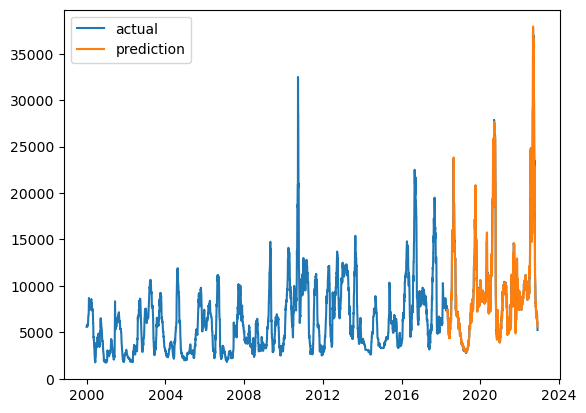

In [90]:
plt.plot(target.index.to_list(), target.values, label="actual")
plt.plot(target.index[target_len:], y_pred_inverse, label="prediction")
plt.legend()
plt.show()

In [30]:
# lasso cross_val_score  (불가)
X_train, X_test, y_train, y_test = train_test_split(feature_std, target_std, test_size=0.2, random_state=22)

# lasso_cross = Lasso(alpha = 0.0001, max_iter = 200)
# cross_val_lasso = cross_val_score(lasso_cross,X_train, y_train, cv=kfold)

In [34]:
# cross_val_lasso

In [23]:
# get_scorer_names()    # scoring의 이름들을 불러오는 메소드

In [33]:
# y_pred = lasso_cross.predict(X_test)
# print("r2_score : ",r2_score(y_test, y_pred))

In [38]:
# 가격을 뺀 독립변수를 이용한 lasso 모델 학습

X_train, X_test, y_train, y_test = train_test_split(feature_std_except_price, target_std, test_size=0.2, random_state=22)
lasso_test2 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test2.fit(X_train, y_train)
y_pred = lasso_test2.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.8744962730522208
r2 score : 0.19396156394744613


In [40]:
# 전일 가격이 포함된 독립변수를 이용한 lasso 모델 학습

X_train, X_test, y_train, y_test = train_test_split(feature_std_yes_price, target_std, test_size=0.2, random_state=22)
lasso_test3 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test3.fit(X_train, y_train)
y_pred = lasso_test3.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.09584467060578784
r2 score : 0.990317761770852


In [41]:
lasso_test3.coef_

array([ 0.00333892,  0.01310911, -0.00386089,  0.99070853])

In [48]:
df_price = pd.read_csv("../data/price/price_baechoo.csv")
df_price.tail(10)

,구분,평균
5885,2022-12-07,5488.0
5886,2022-12-08,5408.0
5887,2022-12-09,5408.0
5888,2022-12-12,5244.5
5889,2022-12-13,5245.5
5890,2022-12-14,5430.5
5891,2022-12-15,5430.5
5892,2022-12-16,5304.0
5893,2022-12-19,5459.5
5894,2022-12-20,5764.0


In [49]:
df_price = df_price.tail(13)
df_price.head()

,구분,평균
5882,2022-12-01,5462.0
5883,2022-12-05,5982.0
5884,2022-12-06,5502.0
5885,2022-12-07,5488.0
5886,2022-12-08,5408.0


In [50]:
df_price.set_index("구분", inplace=True)
df_price

,평균
구분,
2022-12-01,5462.0
2022-12-05,5982.0
2022-12-06,5502.0
2022-12-07,5488.0
2022-12-08,5408.0
2022-12-09,5408.0
2022-12-12,5244.5
2022-12-13,5245.5
2022-12-14,5430.5


-------------------------------------------------

In [20]:
# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(feature)
feature = scaler.transform(feature)
scaler.fit(target)
target = scaler.transform(target)

# 데이터셋 생성
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 데이터셋 생성
look_back = 1
trainX, trainY = create_dataset(feature, look_back)
testX, testY = create_dataset(target, look_back)

# 데이터셋 형태 변환
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 데이터 스케일링 복원
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 모델 평가
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

# 예측 결과 시각화
plt.figure(figsize=(12, 9))
plt.plot(testY[0], label='actual')
plt.plot(testPredict, label='prediction')
plt.legend()
plt.show()

# 예측 결과 저장
predic_df = pd.DataFrame(testPredict)

# 예측 결과 저장


ValueError: Expected 2D array, got 1D array instead:
array=[5600. 5600. 5600. ... 5664. 5592. 5242.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.